# NNMF with cross-validated number of components

INFO:
    - randomized initialization of non-neg least squares in nnlsm_blockpivot(see l. 98 in nnls.py, called by censored_nnlstsq(in cv.py, called by cv_pca(also in cv.py)))
        - repetitions still don't work - give same result. Running different times on the other hand doesn't, so maybe just put function a loop.

TODO:
    - run on server
    - plot components
    - plot cell reconstructions
    - organize code

In [1]:
# Library/module setup
from cv import * # NNMF cross-validation functions

import scipy.io as sio

import matplotlib.pyplot as plt # plotting lib

import multiprocessing # parallel computing
import time # timing computations

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# Load PSTH data (.mat file)
orig_data = sio.loadmat('../data/nnmf_best.mat')
sio.whosmat('../data/nnmf_best.mat')

[('A', (641, 25), 'double'),
 ('D_res', (100, 1), 'double'),
 ('X', (641, 815), 'double'),
 ('Y', (25, 815), 'double'),
 ('k_best', (1, 1), 'double'),
 ('psth', (1, 1), 'struct')]

In [3]:
# Extract PSTH data
data = orig_data['psth']['psth'][0,0] # PSTH array is in nnmf_best.psth.psth
print('data: firing rate PSTH of %i cells x %i tPoints' % data.shape)

data: firing rate PSTH of 815 cells x 641 tPoints


# Fit NNMF model

In [4]:
# Parameters
ranks = [[x] for x in range(1,101)] # range of components to test
repetitions = 100 # number of repetitions
iterator = [(i[0],j+1) for (i,j) in itertools.product(ranks, range(repetitions))]

In [5]:
def nnmf_parallel(rank, repetition, data=data):
    
    ## Set random number generator seed 
    # This is necessary to get different results from multiprocessing.
    # One method is to set the seed to current time. Here, we convert sub-second values to int, because 
    # otherwise, parallel processes starting within the same second will have the same seed.
#     seed = int(str(time.time()).split(".")[1])
    # Another method to easily set reproducible seeds per rank and repetition is this one:
    seed = int(''.join((str(rank), str(repetition)))) # set reproducible seed
    np.random.seed(seed=seed)    

    print('  Fitting model:   rank: %i, repetition: %i seed: %i ...' % (rank, repetition, seed))
    train_err, test_err = cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=True)[2:]
    
    return (rank, train_err, test_err, seed)

In [ ]:
t = time.time()

train_err, test_err = [], [] # initialize vars

# Fit NNMF model (parallel implementation)
n_processes = multiprocessing.cpu_count()
print('Fitting model for ranks %i-%i with %i repetition(s).' % (np.min(ranks), np.max(ranks), repetitions))
print('Running parallelization with %i processes.' % n_processes)
with multiprocessing.Pool(processes=n_processes) as pool:
    temp = pool.starmap(nnmf_parallel, iterator)

train_err = [(i[0], i[1]) for i in temp]
test_err = [(i[0], i[2]) for i in temp]
seeds = [(i[3]) for i in temp]

print('DONE! Execution time: %i s.' % round(time.time() - t))

Fitting model for ranks 1-100 with 100 repetition(s).
Running parallelization with 24 processes.
  Fitting model:   rank: 5, repetition: 21 seed: 521 ...
  Fitting model:   rank: 2, repetition: 6 seed: 26 ...
  Fitting model:   rank: 3, repetition: 11 seed: 311 ...
  Fitting model:   rank: 4, repetition: 16 seed: 416 ...
  Fitting model:   rank: 8, repetition: 36 seed: 836 ...
  Fitting model:   rank: 11, repetition: 51 seed: 1151 ...
  Fitting model:   rank: 14, repetition: 66 seed: 1466 ...
  Fitting model:   rank: 10, repetition: 46 seed: 1046 ...
  Fitting model:   rank: 16, repetition: 76 seed: 1676 ...
  Fitting model:   rank: 12, repetition: 56 seed: 1256 ...
  Fitting model:   rank: 9, repetition: 41 seed: 941 ...
  Fitting model:   rank: 19, repetition: 91 seed: 1991 ...
  Fitting model:   rank: 6, repetition: 26 seed: 626 ...
  Fitting model:   rank: 15, repetition: 71 seed: 1571 ...
  Fitting model:   rank: 7, repetition: 31 seed: 731 ...
  Fitting model:   rank: 22, repetit

In [ ]:
train_err

In [253]:
# Save results
do_save = True

if do_save:
    nnmf_cv_err_per_comp = {'train_err': train_err, 'test_err': test_err, 'seeds': seeds}
    np.save('../data/nnmf_cv_err_per_comp.npy', nnmf_cv_err_per_comp)

In [11]:
# Load if it doesn't exist in workspace
if not ('nnmf_cv_err_per_comp' in locals() or 'nnmf_cv_err_per_comp' in globals()):
    nnmf_cv_err_per_comp = np.load('../data/nnmf_cv_err_per_comp.npy').item()
    test_err = nnmf_cv_err_per_comp['test_err']
    train_err = nnmf_cv_err_per_comp['train_err']

In [17]:
# Find optimal rank / number of components
opt_rank = test_err[np.argmin([x[1] for x in test_err])]
print('Optimal number of components: %i \t MSE: %f' % (opt_rank[0], opt_rank[1]))

Optimal number of components: 53 	 MSE: 0.006901


# Plot

In [196]:
def defaultPlotPars():
    """Defines default plot parameters by changing rcParams.
    TODO: 
        - See if need to output other plot params that cannot be changed in rcParams. 
        - Allow for dict input of parameters.
    """
    from pylab import rcParams as rc

    plot_par = {'font.size': 13.0,
           'axes.linewidth': 1,
           'axes.labelsize': 'large',
           'axes.titlesize': 'large',
           'xtick.labelsize': 'medium',
           'ytick.labelsize': 'medium',
           }
    rc.update(plot_par)
    
    return rc, plot_par

In [194]:
rc, plot_par = defaultPlotPars()

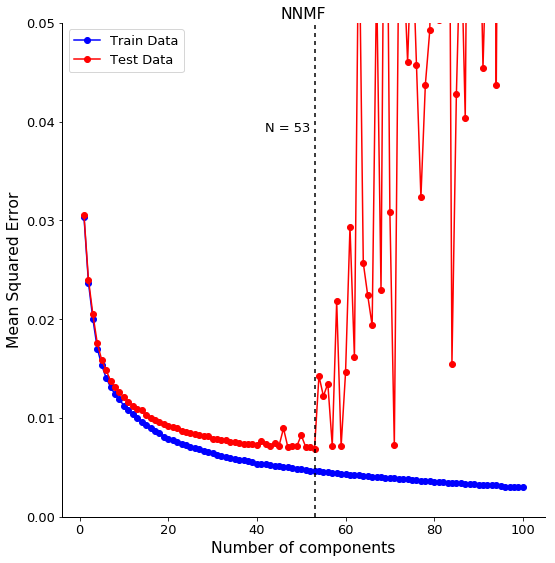

In [205]:
## Plot cross-validated train vs test errors

# Pars
save_fig = False

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(*list(zip(*train_err)), linestyle='-', marker='o', color='b', label='Train Data')
ax.plot(*list(zip(*test_err)), linestyle='-', marker='o', color='r', label='Test Data')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of components')
ax.set_title('NNMF')
ax.axvline(opt_rank[0], color='k', dashes=[2,2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
fig.tight_layout()
ax.set_ylim((0,0.05))
ax.text(opt_rank[0]-1, ax.get_ylim()[1]-0.01, 'N = %i' % opt_rank[0],
        verticalalignment='top', horizontalalignment='right')

if save_fig:
    fig.savefig('../figures/nnmf_crossval_curves.pdf')
    fig.savefig('../figures/nnmf_crossval_curves.png')

In [58]:
# Get ratio of cross-validated train vs test errors
a = [i[1] for i in test_err]
b = [i[1] for i in train_err]

ratio = [i / j for i,j in zip(a,b)]

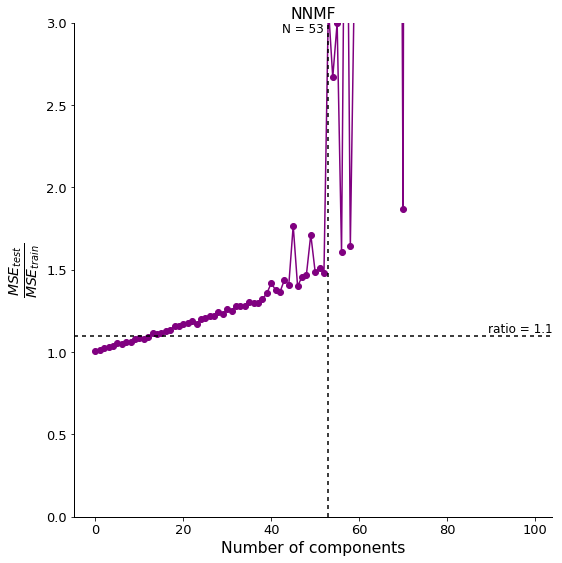

In [207]:
## Plot ratio of cross-validated train vs test errors

# Pars
ratio_cut = 1.1
ylim_cut = 3
save_fig = False

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(ratio, 'o-', color='purple') # label='ratio(test_err / train_err)')
# ax.set_ylabel('$MSE_{test}$ / $MSE_{train}$')
ax.set_ylabel('$\\frac{MSE_{test}}{MSE_{train}}$', Fontsize=20)
ax.set_xlabel('Number of components')
ax.set_title('NNMF')
ax.set_ylim(0, ylim_cut)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Vertical line at optimal number of ranks
ax.axvline(opt_rank[0], color='k', dashes=[2,2])
ax.text(opt_rank[0]-1, ax.get_ylim()[1], 'N = %i' % opt_rank[0], Fontsize=12,
        verticalalignment='top', horizontalalignment='right')
# Horizontal line for ratio cut-off
ax.axhline(ratio_cut, color='k', dashes=[2,2])
ax.text(ax.get_xlim()[1], ratio_cut, 'ratio = %.1f'%ratio_cut,
        Fontsize=12, verticalalignment='bottom', horizontalalignment='right')

ax.legend()
fig.tight_layout()

if save_fig:
    fig.savefig('../figures/nnmf_crossval_curves_ratio.pdf')
    fig.savefig('../figures/nnmf_crossval_curves_ratio.png')

# Fit model w desired number of components

In [223]:
data.shape

(815, 641)

In [249]:
# Define rank / number of components
rank = 30 # opt_rank[0]

# Fit model with optimal number of components
print('Fitting model with %i components...' %rank)
U, Vt, tr_err, te_err = cv_pca(data, rank, nonneg=True)

print('U: Cells and their component weights \t [n_cells x n_components] =', U.shape)
print('Vt: Components and their time weights \t [n_componetns x n_tPoints] =', Vt.shape)

Fitting model with 30 components...
U: Cells and their component weights 	 [n_cells x n_components] = (815, 30)
Vt: Components and their time weights 	 [n_componetns x n_tPoints] = (30, 641)


In [250]:
# Save components for plotting

do_save = True

if do_save:
    # Save as .mat struct to use Miro's plotting scripts
    print('Saving to: '+'../data/nnmf_cv_comps.mat')
    sio.savemat('../data/nnmf_cv_comps.mat',
                {'U': U,
                 'Vt': Vt,
                 'tr_err': tr_err,
                 'te_err': te_err,
                })

Saving to: ../data/nnmf_cv_comps.mat


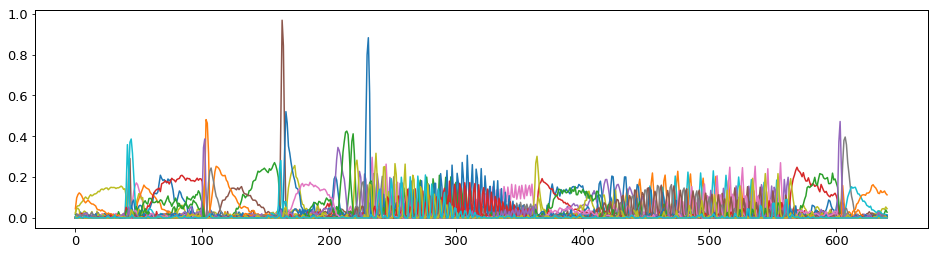

In [248]:
# Plot components
fig, ax = plt.subplots(1, 1, figsize=(16,4))

ax.plot(Vt.T)
plt.show()


# TESTS

In [2]:
# Do dry run with artificial data generated by plot_nmf()
plot_nmf()

Fitting model with rank 1/7 ...
Fitting model with rank 2/7 ...
Fitting model with rank 3/7 ...
Fitting model with rank 4/7 ...
Fitting model with rank 5/7 ...
Fitting model with rank 6/7 ...
Fitting model with rank 7/7 ...
DONE.


In [24]:
# Parameters
# N, R = 150, 4
# noise = .8
repetitions = 2
ranks = np.arange(1, 3)

In [5]:
# Initialize problem
# U = np.random.rand(N, R)
# Vt = np.random.rand(R, N)
# data = np.dot(U, Vt) + noise*np.random.rand(N, N)
# train_err, test_err = [], []

In [25]:
# Fit NNMF models w various k components

train_err, test_err = [], [] # initialize problem

t = time.time() # get execution time
for rnk, _ in itertools.product(ranks, range(repetitions)):
    print('Fitting model with rank %i/%i ...' % (rnk, ranks[-1]))
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))
    
print('DONE! Execution time: %i s.' % round(time.time() - t))

Fitting model with rank 1/2 ...
Fitting model with rank 1/2 ...
Fitting model with rank 2/2 ...
Fitting model with rank 2/2 ...
DONE! Execution time: 91 s.
